In [28]:
from transformers import RobertaTokenizerFast, AutoModelForTokenClassification, AutoModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss, accuracy_score, matthews_corrcoef
from sklearn.metrics import roc_auc_score
from scipy.special import softmax
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# import pickle5 as pickle

In [29]:
import torch
torch.cuda.is_available()

True

In [30]:
OUTPUT_DIR = '../subset_outputs/custom_baseline/'

In [31]:
class CustomBERTClassifier(nn.Module):
    def __init__(self, path, num_classes, plddt = False):
        super(CustomBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(path)
        self.dropout = nn.Dropout(0.1)  # Adjust dropout rate as needed
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.plddt = plddt
        if plddt:
            self.fc = nn.Linear(self.bert.config.hidden_size + 1, num_classes)

    def forward(self, input_ids, attention_mask, plddts=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state
        if plddts is not None and self.plddt:
            pooled_output = torch.concat((pooled_output, plddts.unsqueeze(-1)), dim=2)
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

In [32]:
PRETRAINED_MODEL = "../checkpoint-final/"
NUM_CLASSES=2
best_model_path = '../subset_outputs/custom_baseline/best_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = RobertaTokenizerFast.from_pretrained("../checkpoint-final/")
best_ft_model = CustomBERTClassifier(PRETRAINED_MODEL, NUM_CLASSES)
best_ft_model.load_state_dict(torch.load(best_model_path))
best_ft_model.to(device)
df_test = pd.read_pickle('../Datasets/subset_test.pkl')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaModel were not initialized from the model checkpoint at ../checkpoint-final/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
def precision_recall_f1_roc_convolve(name, logits, labels, convolution):
    logits = [i[1] for i in logits]
    convolved = np.convolve(np.array(logits).flatten(), np.array(convolution / np.sum(convolution).flatten()), 'same')
    p = [(1 - i, i) for i in convolved]
    roc = [i[1] for i in p]
    p = np.argmax(p, axis=-1)
    precision, recall, f1, support = precision_recall_fscore_support(labels, p)
    roc_auc = roc_auc_score(labels, roc)
    mcc = matthews_corrcoef(labels, p)
    return {
        f'precision_{name}':precision[1],
        f'recall_{name}':recall[1],
        f'f1_{name}':f1[1],
        f'roc_auc_{name}':roc_auc,
        f'MCC_{name}':mcc,
    }

def compute_metrics(logits, labels):
    logits = softmax(logits, axis=1)
    l = labels
#     l = []
#     for j, i in enumerate(labels):
#         l = l + list(i)
#     print(len(l), len(logits))
    lg2 = logits
    metrics = {}
    metrics.update(precision_recall_f1_roc_convolve('normal', lg2, l, [1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa5', lg2, l, [1,1,1,1,1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa9', lg2, l, [1,1,1,1,1,1,1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa15', lg2, l, [1]*15))
#     metrics.update(precision_recall_f1_roc_convolve('linear5', lg2, l, [1,2,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('linear9', lg2, l, [1,2,3,4,5,4,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('linear15', lg2, l, [1,2,3,4,5,6,7,8,7,6,5,4,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad5', lg2, l, [1,3,9,3,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad9', lg2, l, [1,3,9,27,81,27,9,3,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad15', lg2, l, [1,3,9,27,81,243,729,2187,729,243,81,27,9,3,1]))
    
    return metrics

def model_out(encoded, model):
    """Given encoding, pass through model to get logits. Returns logits."""
    encoded.to(device)
    with torch.no_grad():
        output = model(**encoded)
    return output

def get_word_vector(sent, tokenizer, model):
    """Returns logits."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt", truncation=True, max_length=1024)
    out = model_out(encoded, model)
    return out

In [34]:
device = torch.device('cuda')
best_ft_model.to(device)

CustomBERTClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(35, 768, padding_idx=1)
      (position_embeddings): Embedding(1026, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [35]:
Xs = []
labs = []
for index, row in df_test.iterrows():
    seq = row['Sequence']
    lab = list(row['full'])
    word_embedding = get_word_vector(seq[:min(1024, len(seq))], tokenizer, best_ft_model)
    word_embedding = word_embedding[0]
    word_embedding = word_embedding[1:-1]
    word_embedding = word_embedding.cpu()
    word_embedding_full = np.squeeze(word_embedding.numpy())
#     print(word_embedding.shape)
    if len(seq) > 2044:
        for i in range(1022, len(seq) - 1022, 1022):
            word_embedding = get_word_vector(seq[i:i+1022], tokenizer, best_ft_model)
            word_embedding = word_embedding[0]
            word_embedding = word_embedding[1:-1]
            word_embedding = word_embedding.cpu()
            word_embedding = np.squeeze(word_embedding.numpy())
            word_embedding_full = np.concatenate([word_embedding_full, word_embedding], axis=0)
    if len(seq) > 1024:
        word_embedding = get_word_vector(seq[len(seq) - 1022:len(seq)], tokenizer, best_ft_model)
        word_embedding = word_embedding[0]
        word_embedding = word_embedding[1:-1]
        word_embedding = word_embedding.cpu()
        word_embedding = np.squeeze(word_embedding.numpy())
        overlap_amount = 1022 - (len(seq) % 1022)
        overlap = word_embedding_full[(-1 * overlap_amount):]
        word_embedding_full[(-1 * overlap_amount):] = (overlap + word_embedding[:overlap_amount]) / 2
        end_chunk = word_embedding[overlap_amount:]
        word_embedding_full = np.concatenate([word_embedding_full, end_chunk], axis=0)
#     print(word_embedding_full.shape, len(seq))
    Xs.append(word_embedding_full)
    labs.append(lab[:len(seq)])
    
    

In [36]:
Xs = np.concatenate(Xs)
labs = np.concatenate(labs)
metrics = compute_metrics(Xs, labs)
metrics

{'precision_normal': 0.44892286309937457,
 'recall_normal': 0.34796660382440076,
 'f1_normal': 0.39204976483082987,
 'roc_auc_normal': 0.7892344235794801,
 'MCC_normal': 0.2954022547059736}

In [37]:
# Load data (deserialize)
with open(f'{OUTPUT_DIR}losses.pkl', 'rb') as f:
    losses = pickle.load(f)

train_losses = losses['train']
val_losses = losses['val']

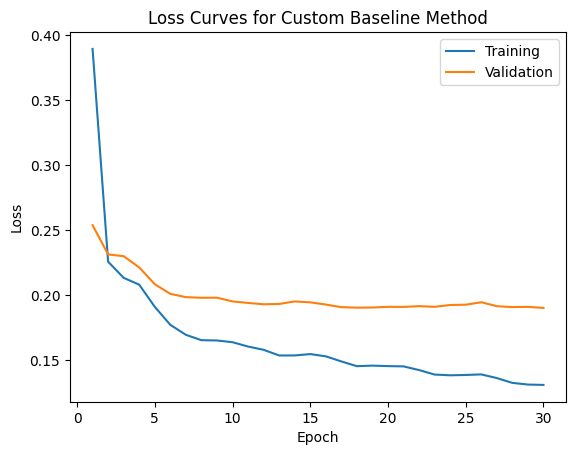

In [40]:
plt.plot(list(range(1, 31)), train_losses)
plt.plot(list(range(1, 31)), val_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss Curves for Custom Baseline Method')
plt.legend(['Training', 'Validation'])
plt.show()